In [1]:
import keras

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
#from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras import backend as K

import h5py
import os
import shutil
import csv
import pickle

from PIL import Image

import numpy as np
from numpy import argmax

import seaborn as sn
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

versionstring = 'run_26_InceptionV3_single_scaled_sample'

Using TensorFlow backend.


In [2]:
img_height = 299
img_width = 299
CROP_LENGTH = 299
batch_size = 32
n_examples = 3
nr_of_output_classes = 69

# Training, test, and validation directories 
train_dir       = os.getcwd() + '/data/single_crop/train'
val_dir         = os.getcwd() + '/data/single_crop/valid'
test_dir        = os.getcwd() + '/data/single_crop/test'

In [ ]:
log_dir = os.getcwd() + '/logs/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

save_dir = log_dir + versionstring + '/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
model_dir = save_dir + 'models/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

history_dir = save_dir + 'history/'
if not os.path.exists(history_dir):
    os.makedirs(history_dir)

print(log_dir)
print(save_dir)
print(model_dir)
print(history_dir)

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen  = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        val_dir,
        target_size=(299, 299),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 14076 images belonging to 69 classes.
Found 1794 images belonging to 69 classes.
Found 1794 images belonging to 69 classes.


## InceptionV3

In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=None,
               input_shape=(img_width,img_height,3))

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.8)(x)
predictions = Dense(nr_of_output_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#model.summary()

In [7]:
for layer in model.layers:
   layer.trainable = True

#model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [8]:
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1,
                              mode='auto', baseline=None, restore_best_weights=False)

checkpoint = ModelCheckpoint(filepath=model_dir+'Low_val_acc_{epoch:02d}.h5', monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=False, period=1)

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = valid_generator, 
      validation_steps = valid_generator.samples // batch_size,
      epochs=50, callbacks=[checkpoint, earlystopping])

In [10]:
model.save(model_dir+'Last_epoch.h5')

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

In [12]:
with open(history_dir + 'acc.pickle', "wb") as x:
    pickle.dump(acc, x)
with open(history_dir + 'val_acc.pickle', "wb") as x:
    pickle.dump(val_acc, x)
with open(history_dir + 'loss.pickle', "wb") as x:
    pickle.dump(loss, x)
with open(history_dir + 'val_loss.pickle', "wb") as x:
    pickle.dump(val_loss, x)

## Kernel allowed to restart from here on

In [13]:
with open(history_dir + 'acc.pickle', "rb") as x:
    acc = pickle.load(x)
with open(history_dir + 'val_acc.pickle', "rb") as x:
    val_acc = pickle.load(x)
with open(history_dir + 'loss.pickle', "rb") as x:
    loss = pickle.load(x)
with open(history_dir + 'val_loss.pickle', "rb") as x:
    val_loss = pickle.load(x)
epochs = range(1, len(acc) + 1)

## Show training

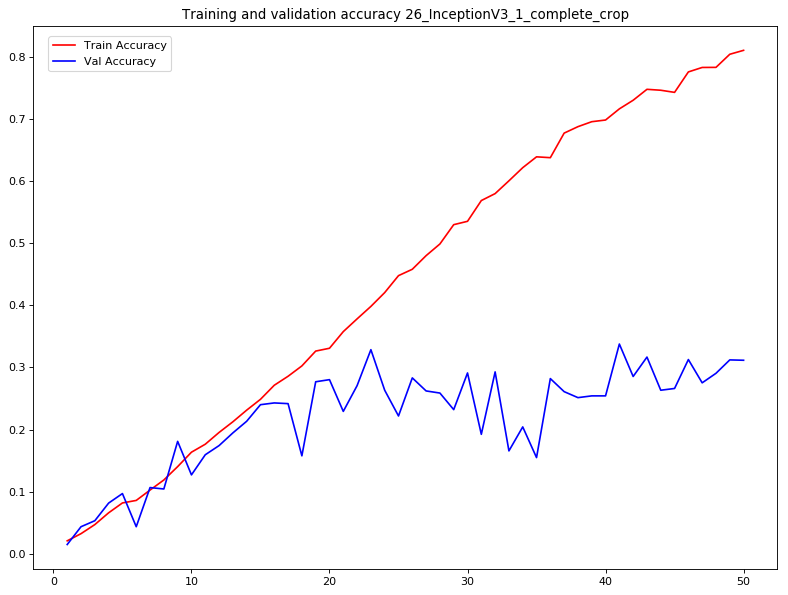

In [14]:
plt.figure(figsize=(12, 9), dpi=80)

plt.plot(epochs, acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Val Accuracy')

plt.title('Training and validation accuracy '+versionstring)
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)

plt.show()

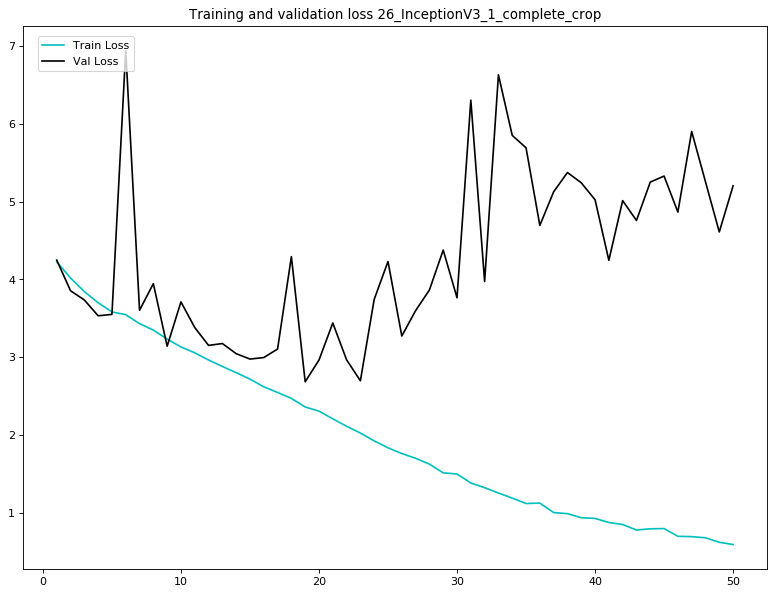

In [15]:
plt.figure(figsize=(12, 9), dpi=80)

plt.plot(epochs, loss, 'c', label='Train Loss')
plt.plot(epochs, val_loss, 'k', label='Val Loss')

plt.title('Training and validation loss '+versionstring)
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)

plt.show()

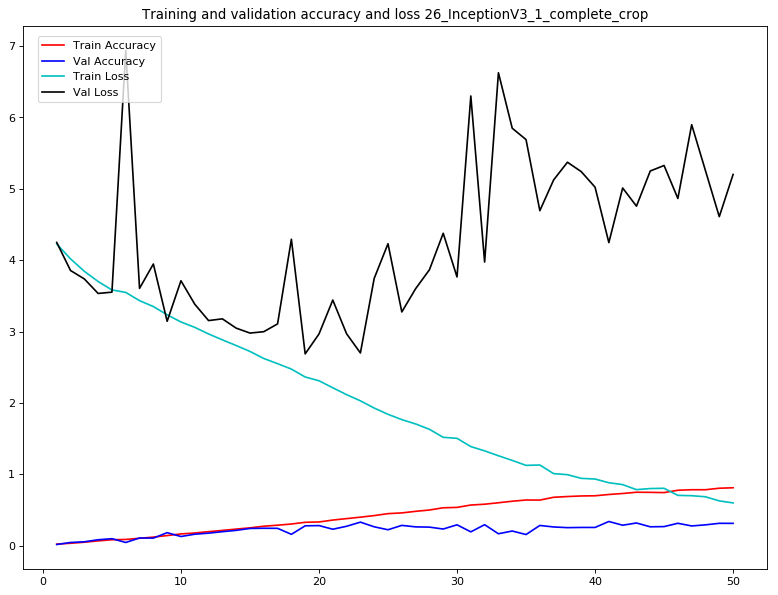

In [16]:
plt.figure(figsize=(12, 9), dpi=80)

plt.plot(epochs, acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Val Accuracy')
plt.plot(epochs, loss, 'c', label='Train Loss')
plt.plot(epochs, val_loss, 'k', label='Val Loss')

plt.title('Training and validation accuracy and loss '+versionstring)
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)

plt.show()

# Test set performance

In [17]:
model = load_model(model_dir+'Low_val_acc_19.h5')

In [18]:
y_pred = model.predict_generator(test_generator, test_generator.samples//batch_size + 1,
                                 workers=1, use_multiprocessing=False, verbose = 1)

57/57 [==============================] - 9s 157ms/step


In [19]:
y_est = np.argmax(y_pred,axis=1)

In [20]:
cm = confusion_matrix(test_generator.classes,y_est)

mat = np.matrix(cm)
dataframe = pd.DataFrame(data=mat.astype(float))
csvfilename = save_dir+'CM.csv'
dataframe.to_csv(csvfilename, sep=',', header=False, float_format='%.f', index=False)

In [21]:
print(accuracy_score(test_generator.classes,y_est))

0.2725752508361204


In [22]:
classes = sorted(os.listdir(test_dir))
classification_report = classification_report(test_generator.classes, y_est, target_names=classes, digits=4)

In [ ]:
print(classification_report)

## Confusion matrix

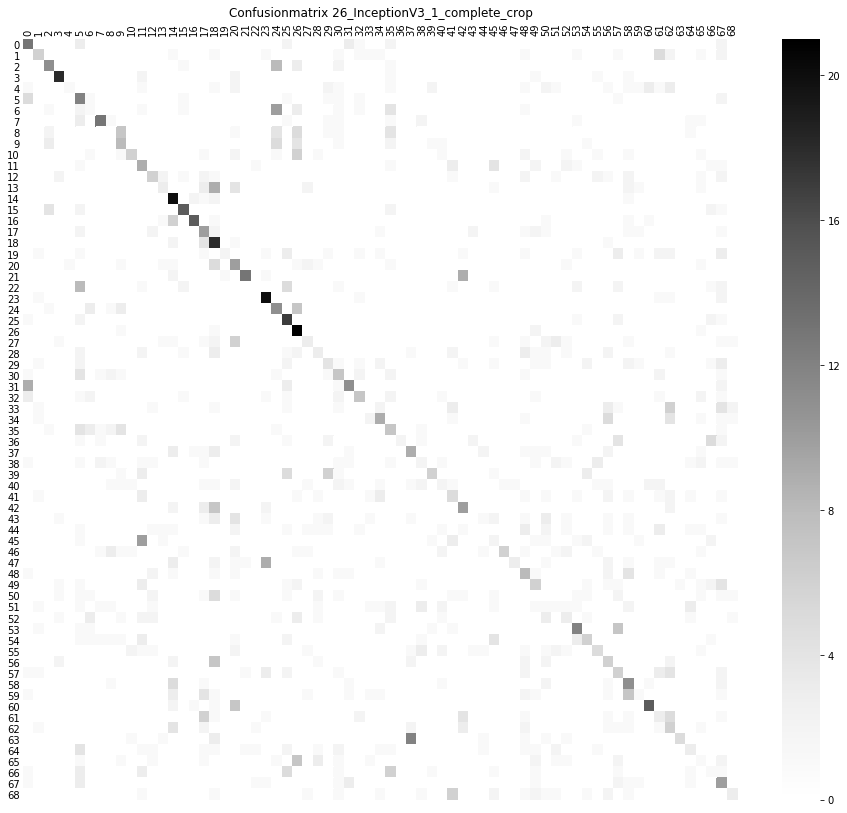

In [24]:
df_cm = pd.DataFrame(cm, range(nr_of_output_classes),
                  range(nr_of_output_classes))

plt.figure(figsize = (16,14))
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.tick_params(axis='both', which='both', length=0)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Confusionmatrix '+versionstring)

sn.heatmap(df_cm, annot=False, cmap="Greys")

plt.show()

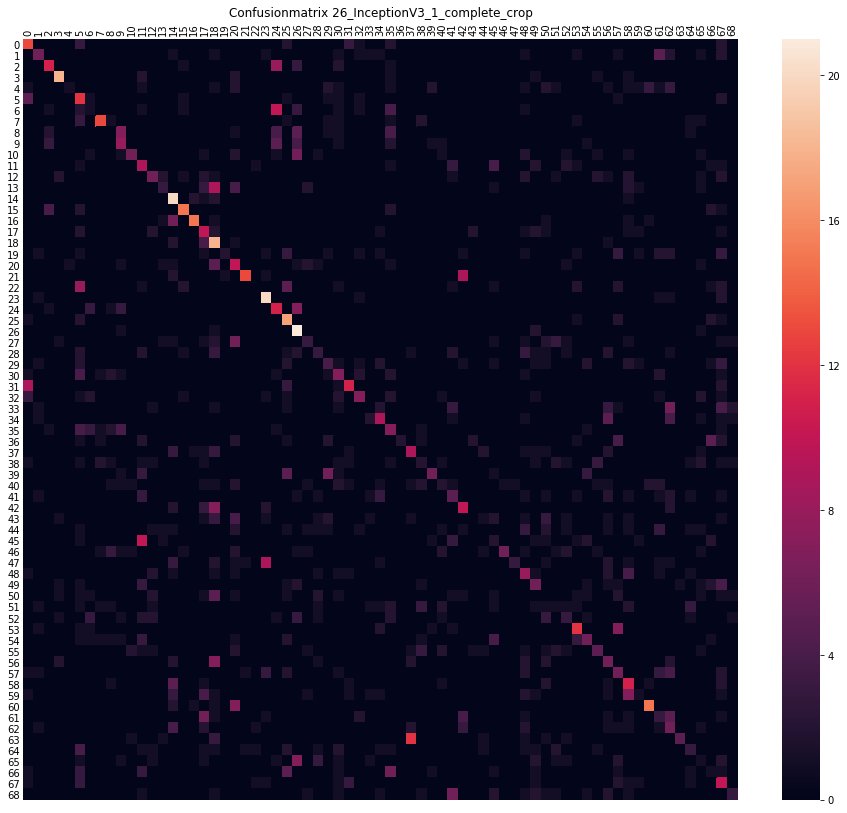

In [25]:
df_cm = pd.DataFrame(cm, range(nr_of_output_classes),
                  range(nr_of_output_classes))

plt.figure(figsize = (16,14))
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.tick_params(axis='both', which='both', length=0)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Confusionmatrix '+versionstring)

sn.heatmap(df_cm, annot=False)

plt.show()